## Paquid Data Test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from jmstate import MultiStateJointModel
from lifelines import ExponentialFitter
import scipy
from sklearn.neighbors import KernelDensity
from jmstate.utils import *
import jmstate

In [2]:
# Lecture du fichier CSV
paquid = pd.read_csv('Data/paquid.csv')

In [3]:
def norm_mmse(x):
    transfY = np.array([
        0, 2.91, 5.48, 7.76, 9.77, 11.57, 13.19, 14.67, 16.05, 17.37,
        18.68, 20.01, 21.38, 22.83, 24.39, 26.07, 27.91, 29.93, 32.17,
        34.64, 37.37, 40.4, 43.74, 47.4, 51.44, 55.98, 61.18, 67.25,
        74.61, 84.32, 100
    ]) / 100.0

    # Return transformed values, same shape as input
    result = [transfY[int(elt)] if not np.isnan(elt) else elt for elt in x]
    return np.array(result)

def norm_age(x):
    return x - 65.0

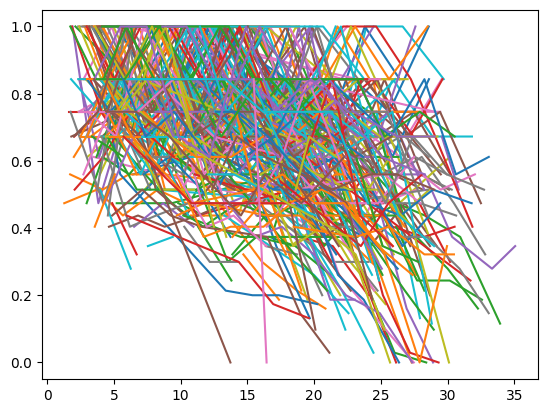

In [4]:
def get_ages(id):
    T = []
    for k in range(4):
        mask = (paquid['ID'].values == id) & (paquid['HIER'].values == k)
        if sum(mask) > 0:
            T.append((min(paquid['age'][mask]), k))

    if len(T) <= 1:
        return T
    
    result = [T[0]]  
    
    for i in range(1, len(T)):
        if T[i][0] >= result[-1][0]:
            result.append(T[i])
    
    return result

get_last_visit_age = lambda id: paquid[paquid['ID'] == id]['age'].max()
get_t = lambda id: torch.tensor(norm_age(paquid[paquid['ID'] == id]['age'].values))
get_X = lambda id: torch.tensor(paquid[paquid['ID'] == id]['CEP'].min())
get_Y = lambda id: torch.tensor(norm_mmse(paquid[paquid['ID'] == id]['MMSE'].values))

ids = range(1, 501)
trajectories = [get_ages(id) for id in ids]
c = torch.tensor([get_last_visit_age(id) for id in ids])
t = torch.nn.utils.rnn.pad_sequence([get_t(id) for id in ids], batch_first=True, padding_value=torch.nan)
x = torch.tensor([[get_X(id)] for id in ids])
y = torch.nn.utils.rnn.pad_sequence([get_Y(id) for id in ids], batch_first=True, padding_value=torch.nan)[..., None]

plt.plot(t.T, y[:, :, 0].T)
plt.show()

In [5]:
buckets = build_buckets(trajectories)
print(buckets.keys())

dict_keys([(1, 3), (0, 1), (1, 2), (0, 2), (2, 3), (0, 3)])


In [6]:
surv_params = {}
for key, value in buckets.items():
    _, t0, t1 = buckets[key]
    exp_fit = ExponentialFitter().fit(t1 - t0)
    surv_params[key] = torch.tensor(exp_fit.lambda_, dtype=torch.float32)

In [7]:
def sigmoid(t, x, psi):
    b = psi[:, [0]]
    c = psi[:, [1]]

    res = torch.sigmoid(b * (c - t))
    return res[:, :, None] 

def link(t, x, psi):
    b = psi[:, [0]]
    c = psi[:, [1]]

    s = torch.sigmoid(b * (c - t))      

    f = s                 
    fp = -b * s * (1.0 - s)  

    return torch.stack((f, fp), dim=2)  

def f(gamma, b):
    psi = gamma + b  
    return torch.nn.functional.softplus(psi)      

In [8]:
surv = {
    key: (jmstate.base_hazard.exponential(surv_params[key]), link)
    for key in buckets.keys()
}

init_gamma = torch.zeros(2)
init_Q_inv = torch.zeros(3)
init_R_inv = torch.zeros(1)

init_alphas = {
    key: torch.zeros(2)
    for key in buckets.keys()
}

init_betas = {
    key: torch.zeros(1)
    for key in buckets.keys()
}

init_params = ModelParams(
    init_gamma,
    (init_Q_inv, "full"),
    (init_R_inv, "ball"),
    init_alphas,
    init_betas
)

model_design = ModelDesign(
    f,
    sigmoid,
    surv,
)

model = MultiStateJointModel(model_design, init_params)

In [9]:
data = ModelData(
    x,
    t,
    y,
    trajectories,
    c
)

In [10]:
history = []
callback = lambda : history.append([p.detach().clone() for p in model.params_.as_list])
model.fit(data, n_iter=2000, callback=callback)

Fitting joint model: 100%|██████████| 2000/2000 [03:12<00:00, 10.38it/s]


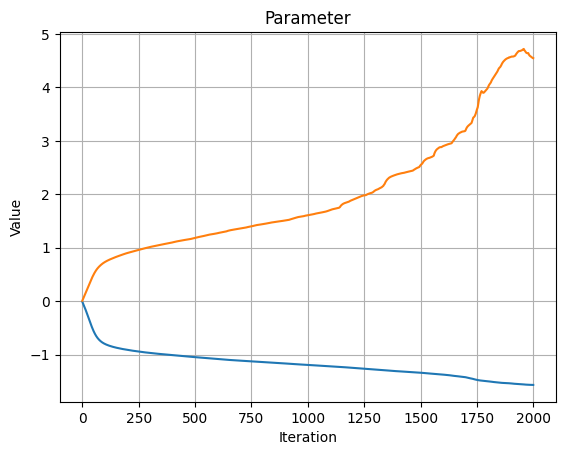

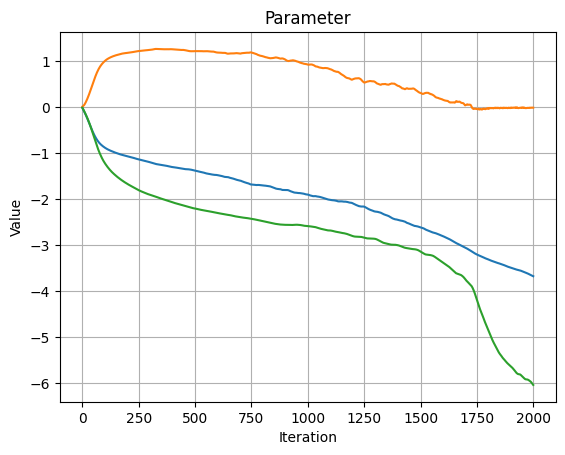

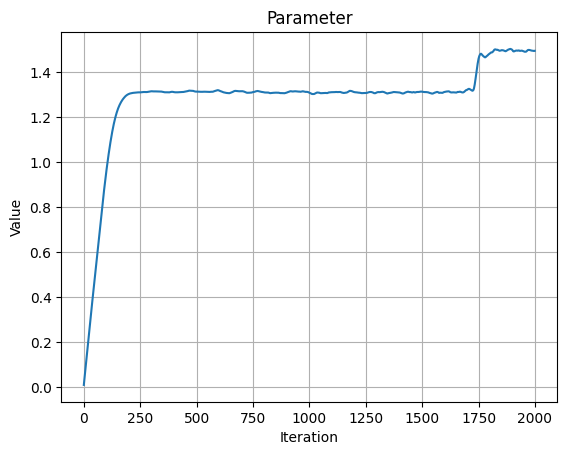

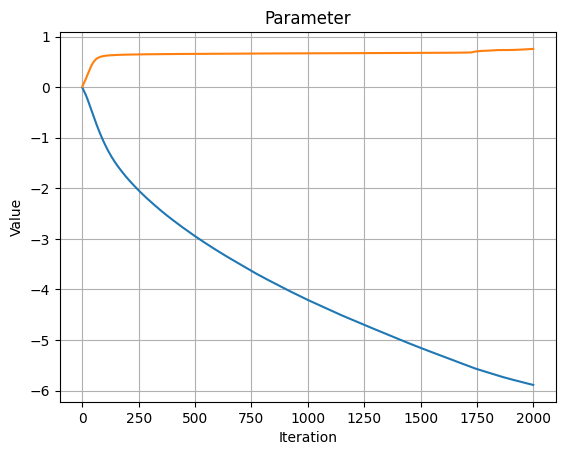

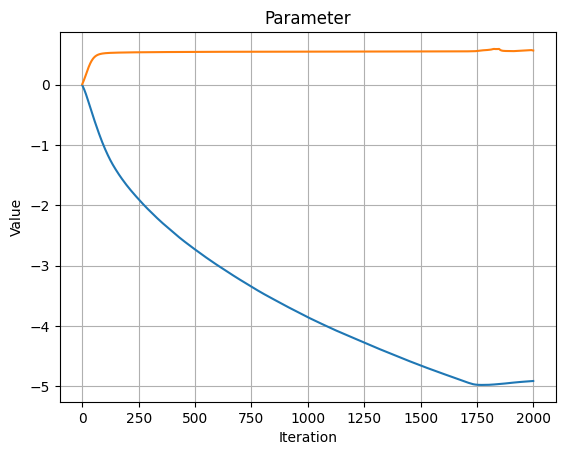

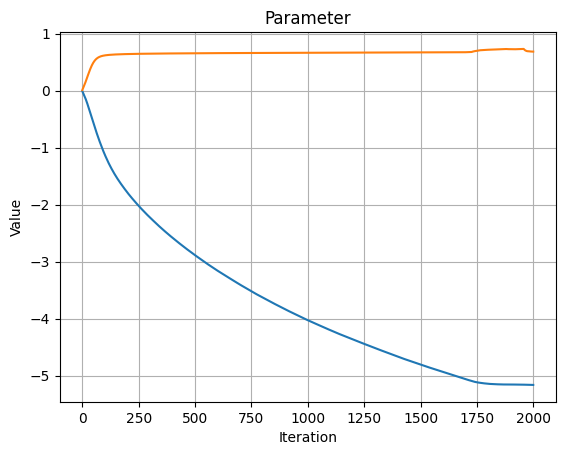

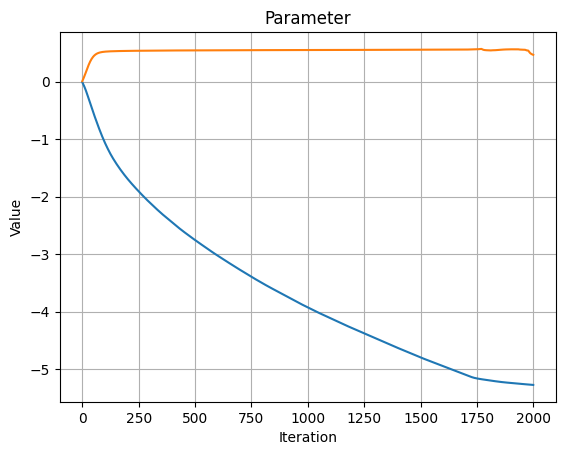

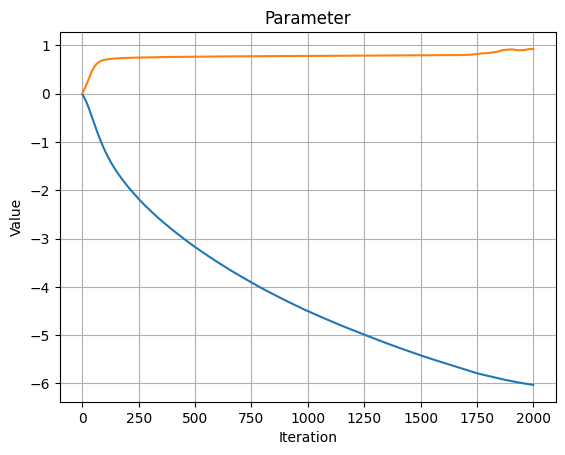

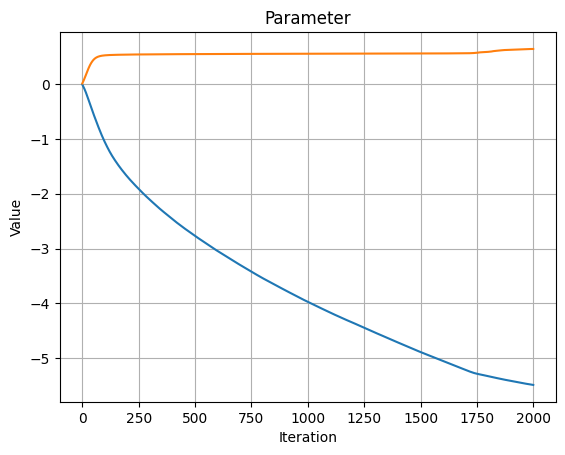

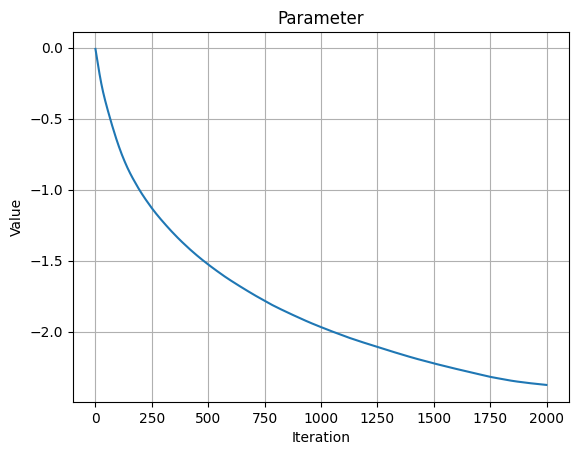

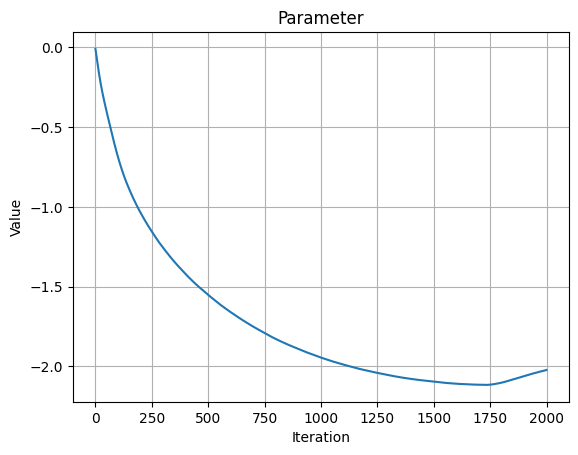

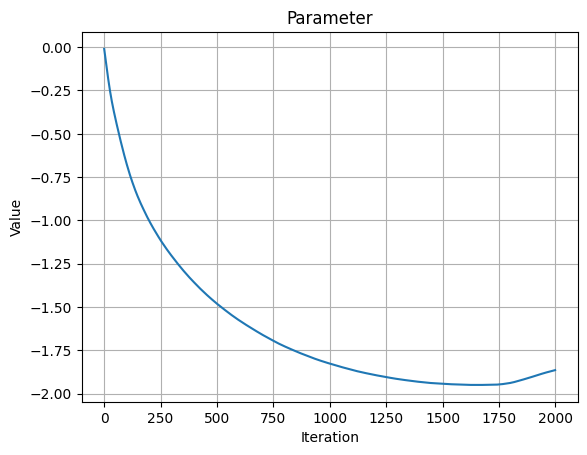

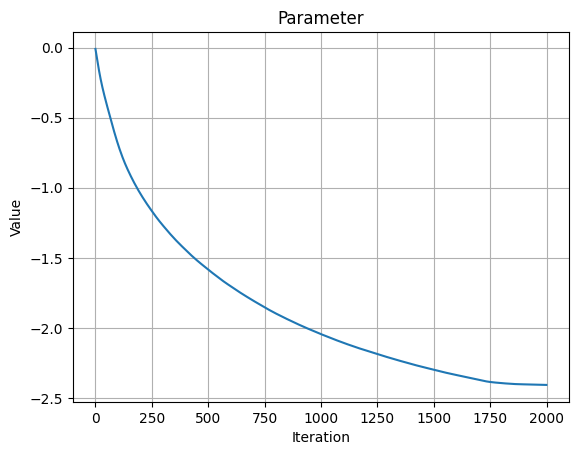

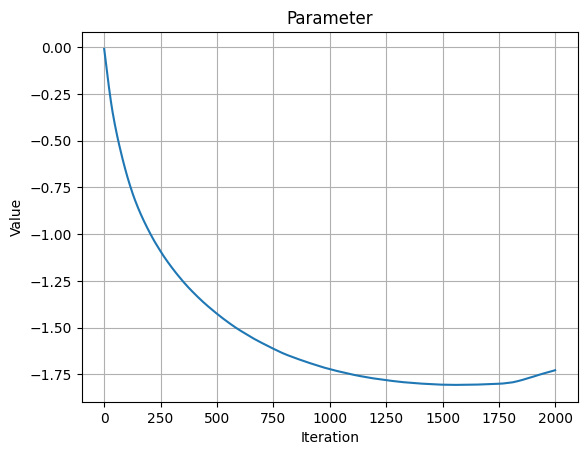

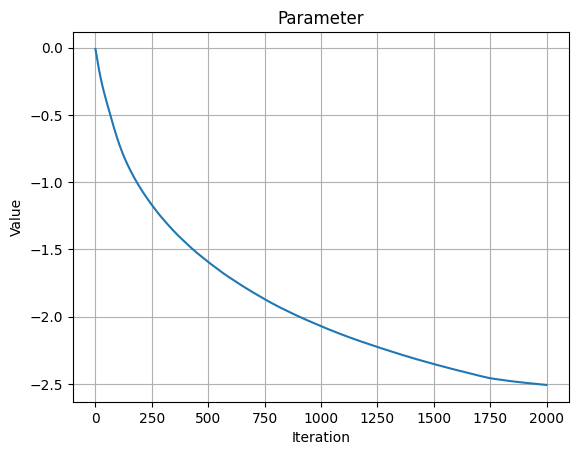

In [11]:

for i in range(len(history[0])):
    history_vstack = np.vstack([elt[i].numpy().reshape(1, -1) for elt in history])

    for j in range(history_vstack.shape[1]):
        plt.plot(np.arange(history_vstack.shape[0]), history_vstack[:, j])

    plt.title(f"Parameter")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

In [12]:
print(model.params_)

ModelParams(gamma=tensor([-1.5663,  4.5472], requires_grad=True), Q_repr=(tensor([-3.6711, -0.0097, -6.0326], requires_grad=True), 'full'), R_repr=(tensor([1.4946], requires_grad=True), 'ball'), alphas={(1, 3): tensor([-5.8870,  0.7559], requires_grad=True), (0, 1): tensor([-4.9107,  0.5656], requires_grad=True), (1, 2): tensor([-5.1644,  0.6835], requires_grad=True), (0, 2): tensor([-5.2761,  0.4670], requires_grad=True), (2, 3): tensor([-6.0315,  0.9252], requires_grad=True), (0, 3): tensor([-5.4862,  0.6379], requires_grad=True)}, betas={(1, 3): tensor([-2.3742], requires_grad=True), (0, 1): tensor([-2.0230], requires_grad=True), (1, 2): tensor([-1.8642], requires_grad=True), (0, 2): tensor([-2.4065], requires_grad=True), (2, 3): tensor([-1.7273], requires_grad=True), (0, 3): tensor([-2.5063], requires_grad=True)})


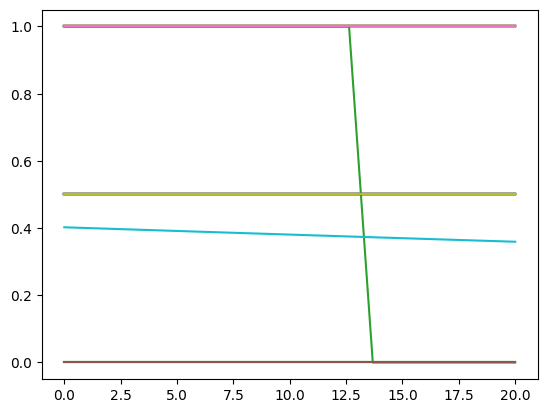

In [13]:
N = 50

Q = model.params_.get_cholesky("Q").detach()
Q = torch.linalg.inv(Q)

R = model.params_.get_cholesky("R").detach()
R = torch.linalg.inv(R)

b_sim = torch.randn(N, model.params_.gamma.detach().shape[0]) @ Q
psi_sim = f(model.params_.gamma, b_sim)
x_sim = KernelDensity().fit(x).sample(N)

y_sim = model.model_design.h(torch.linspace(65, 95, 20), x_sim, psi_sim)
#y_sim += torch.randn_like(y_sim) @ R
plt.plot(torch.linspace(0, 20, 20), y_sim.squeeze(-1).T.detach().numpy())
plt.show()

In [16]:
trajectories_init = [trajectory[:1] for trajectory in trajectories[:N]]

sample_data = SampleData(x_sim, trajectories_init, psi_sim)

trajectories_sim = model.sample_trajectories(sample_data, [95.0 for _ in range(N)])

In [17]:
print(trajectories_sim)

[[(68.5063, 2), (71.38706970214844, 3)], [(66.9954, 1), (73.28250122070312, 2), (77.9937744140625, 3)], [(72.5924, 1), (75.287353515625, 2), (85.19149780273438, 3)], [(73.9535, 1)], [(68.3984, 0), (70.1636962890625, 3)], [(73.1908, 0), (73.67832946777344, 2)], [(85.5787, 2)], [(74.229, 1), (74.24134826660156, 3)], [(80.7755, 1)], [(81.0601, 1), (82.43885803222656, 2)], [(83.6773, 2)], [(74.8984, 1)], [(84.3357, 1), (84.93240356445312, 3)], [(78.815, 2)], [(71.6429, 1)], [(84.2728, 2), (92.41183471679688, 3)], [(69.8426, 0), (91.33172607421875, 1)], [(70.3315, 0), (73.92999267578125, 2), (76.33097839355469, 3)], [(86.6566, 2)], [(79.1894, 2), (81.9061279296875, 3)], [(78.169951198, 0), (80.07981872558594, 1), (84.87260437011719, 3)], [(68.565, 1)], [(70.2043, 1), (72.50468444824219, 3)], [(66.5979, 0), (68.06836700439453, 1), (69.35256958007812, 3)], [(78.5595, 2)], [(68.4351, 0), (68.43793487548828, 3)], [(84.3737, 2), (88.92105102539062, 3)], [(84.2777, 1), (84.30584716796875, 2), (84